Anchor explanations for CIFAR-100 dataset using Resnet50 with pretrained ImageNet

Links:

- https://docs.seldon.io/projects/alibi/en/stable/methods/Anchors.html

- https://docs.seldon.io/projects/alibi/en/stable/api/alibi.explainers.html#alibi.explainers.AnchorImage

- https://docs.seldon.io/projects/alibi/en/stable/examples/anchor_image_imagenet.html

Libraries

In [1]:
 !pip install alibi

In [2]:
# import libraries
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
#from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar100 # for CIFAR-100 dataset

#from alibi.datasets import load_cats # images of various cat breeds
from alibi.explainers import AnchorImage
from skimage.segmentation import slic

Load model pre-trained on ImageNet

In [3]:
#model = InceptionV3(weights = 'imagenet') # load InceptionV3
model = ResNet50(weights = 'imagenet') # load ResNet50

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Load and pre-process sample images

In [5]:
# set target size of image
image_shape = (224, 224, 3) # (224, 224, 3) for ResNet50; (299, 299, 3) for InceptionV3

In [4]:
# load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
NUM_CLASSES = 100

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [6]:
# classes for CIFAR-100 dataset
cifar100_classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck',
'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon',
'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk',
'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower',
'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

In [7]:
len(cifar100_classes)

100

In [8]:
x_test.shape

(10000, 32, 32, 3)

In [9]:
x_train.shape

(50000, 32, 32, 3)

In [38]:
# select first N images from test dataset, N = 5 in our case
subset_length = 5
subset_images = x_test[:subset_length]


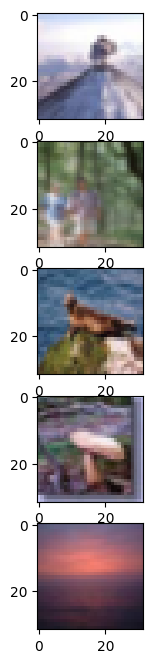

In [39]:
# plot images from the subset of images
fig = plt.figure(figsize=(8,8))
for i in range(subset_length):
  ax = fig.add_subplot(5, 1, i+1)
  ax.imshow(subset_images[i])
plt.show()

In [12]:
subset_images.shape

(5, 32, 32, 3)

apply image preprocessing, make predictions, map predictions back to categories

In [13]:
resized_images = [] # list of resized images
for i in range(subset_length):
  resized_image = smart_resize(subset_images[i], image_shape[:2])
  resized_images.append(resized_image)

In [14]:
# check output
print(x_test[0].shape)
print(resized_images[0].shape)

(32, 32, 3)
(224, 224, 3)


In [15]:
preprocessed_images = [] # list of preprocessed images
for i in range(subset_length):
  preprocessed_image = preprocess_input(np.expand_dims(resized_images[i], axis = 0))
  #preds = model.predict(preprocessed_image)
  #label = decode_predictions(preds, top=3)
  #print(label[0])
  preprocessed_images.append(preprocessed_image)

preprocessed_images[0].shape

(1, 224, 224, 3)

In [16]:
# explainer expects images in 0-1 range, CIFAR is 0-255 => scale valued between 0-1
# normalize input
norm_images = [] # list of normalized images
for i in range(subset_length):
  norm_image = resized_images[i] / 255.0
  norm_images.append(norm_image)

norm_images[0].shape

(224, 224, 3)

define prediction function

In [17]:
predict_fn = lambda x: model.predict(x)

initialize anchor image explainer

In [18]:
segmentation_fn = 'slic' # used segmentation method
kwargs = {'n_segments': 15, 'compactness': 10, 'sigma': .5, 'start_label': 0} # 'n_segments': 15,  'compactness': 20
explainer = AnchorImage(predict_fn, image_shape, segmentation_fn=segmentation_fn,
                        segmentation_kwargs=kwargs, images_background=None)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


explain a prediction

- returns a mask with the superpixels that constitute the anchor.

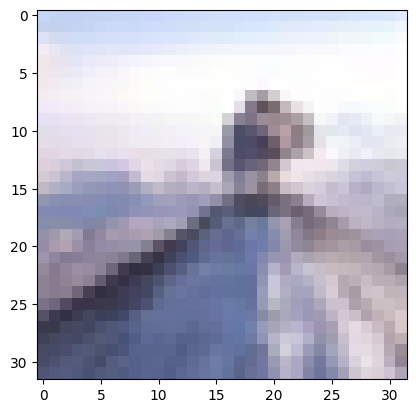

In [20]:
# for dataset from CIFAR-100
plt.imshow(x_test[0])

In [21]:
cifar100_classes[y_test[0][0]]

'mountain'

In [23]:
print("image", "class", "code")
for i in range(subset_length):
  print(i, cifar100_classes[y_test[i][0]], y_test[i][0]) # image, class, code for label

image class code
0 mountain 49
1 forest 33
2 seal 72
3 mushroom 51
4 sea 71


In [24]:
# for CIFAR-100 example
np.random.seed(42)
explanation_images = [] # list of explanations for each image
for i in range(subset_length):
  explanation = explainer.explain(norm_images[i], threshold=.75, p_sample=.5, tau=0.25)
  explanation_images.append(explanation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step


superpixels in the anchor

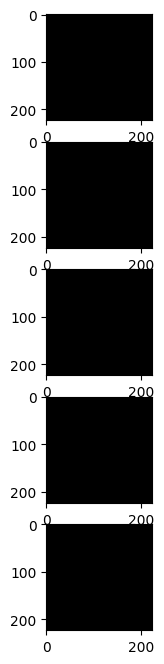

In [25]:
# anchors
fig = plt.figure(figsize=(8,8))
for i in range(subset_length):
  ax = fig.add_subplot(5, 1, i+1)
  ax.imshow(explanation_images[i].anchor)
plt.show()

a visualization of all the superpixels

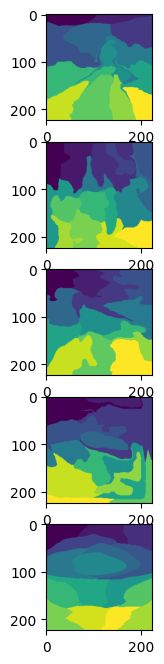

In [26]:
# segments
fig = plt.figure(figsize=(8,8))
for i in range(subset_length):
  ax = fig.add_subplot(5, 1, i+1)
  ax.imshow(explanation_images[i].segments)
plt.show()

Create a heatmap visualization:

- For example, we can highlight the anchor regions in red overlay

In [27]:
explanation_images[0].anchor.shape

(224, 224, 3)

In [28]:
# create a mask for the anchor regions
def create_anchor_mask(explanation):
  anchor_mask = np.zeros(explanation.segments.shape, dtype=bool)
  for sp in np.unique(explanation.anchor): # iterate through unique superpixel IDs  #np.unique(np.mean(explanation.anchor, axis=1)):
    anchor_mask[explanation.segments == sp] = True # compare segment IDs with superpixel IDs; assign True to matching segment
  return anchor_mask

In [29]:
anchor_mask_images = [] # list of anchor masks for each image
for i in range(subset_length):
  anchor_mask = create_anchor_mask(explanation_images[i])
  anchor_mask_images.append(anchor_mask)

anchor_mask_images[0].shape

(224, 224)

In [30]:
# for example using CIFAR-100
# create an overlay by modifying the original image
def create_anchor_overlay(resized_image, anchor_mask):
  overlay = resized_image.astype(np.uint8).copy()
  overlay[anchor_mask] = [255, 0, 0] # red tint on anchor segments [R,G,B], highlight anchor regions in red
  return overlay

In [31]:
overlay_images = [] # list of overlays for each image
for i in range(subset_length):
  overlay = create_anchor_overlay(resized_images[i], anchor_mask_images[i])
  overlay_images.append(overlay)

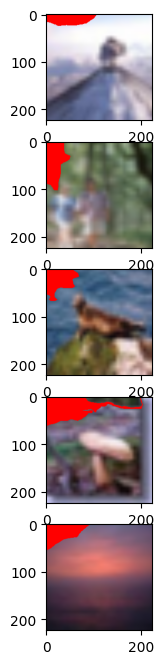

In [32]:
# overlays
fig = plt.figure(figsize=(8,8))
for i in range(subset_length):
  ax = fig.add_subplot(5, 1, i+1)
  ax.imshow(overlay_images[i])
plt.show()

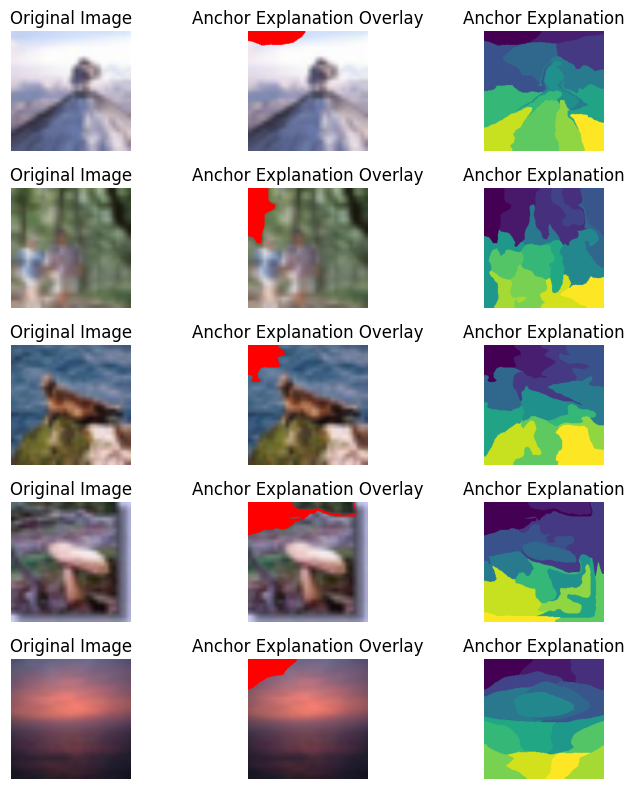

In [33]:
# plot orginal and anchor overlay

fig, ax = plt.subplots(subset_length, 3, figsize=(8,8))
for i in range(subset_length):
  ax[i, 0].imshow(resized_images[i].astype(np.uint8))
  ax[i, 0].set_title("Original Image")
  ax[i, 0].axis('off')

  ax[i, 1].imshow(overlay_images[i])
  ax[i, 1].set_title("Anchor Explanation Overlay")
  ax[i, 1].axis('off')

  ax[i, 2].imshow(explanation_images[i].segments)
  ax[i, 2].set_title("Anchor Explanation")
  ax[i, 2].axis('off')

plt.tight_layout()
plt.show()

In [35]:
# The 'explanation' object also provides metrics:
for i in range(subset_length): # for all five images
  print("Image ", i)
  print("Precision: ", explanation_images[i].precision)
  print("Coverage: ", explanation_images[i].coverage)
  print("Anchor superpixels:", explanation_images[i].anchor)

Image  0
Precision:  [1.]
Coverage:  1
Anchor superpixels: [[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
Image  1
Precision:  [1.]
Coverage:  1
Anchor superpixels: [[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
Image  2
Precision:  [1.]
Coverage:  1
Anchor superpix